In [453]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd
import random
from cfde import Simple_CF_Descent

%load_ext autoreload
%autoreload 2 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive CF-Descent

This file contains the initial attempts at making CF-Descent work and tests to see it's validity

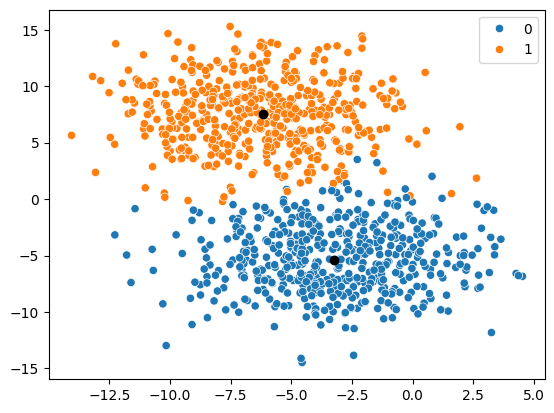

In [454]:
X, y, centers = make_blobs(centers=2, cluster_std=3, n_features=2, n_samples=1000, return_centers=True)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.scatter(x=centers[0][0], y=centers[0][1],color="black")
plt.scatter(x=centers[1][0], y=centers[1][1],color="black")

In [455]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,label
0,-9.085056,11.231079,1.0
1,-12.278748,4.855862,1.0
2,-4.105392,10.567708,1.0
3,-0.299836,0.898896,0.0
4,-11.714474,11.423301,1.0
...,...,...,...
995,-10.020965,7.689841,1.0
996,-2.771174,-10.055011,0.0
997,-2.427556,-13.836552,0.0
998,-3.989142,-10.263522,0.0


In [456]:
x,cf,h = Simple_CF_Descent(df=df, target=1.0, centers=centers)

label_mapping = {0: "cluster 0", 1: "cluster 1"}

mapped_pred = [label_mapping[int(label)] for label in pred]

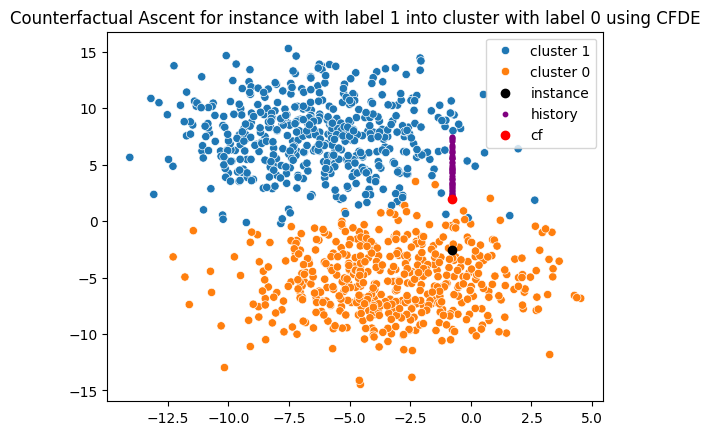

In [457]:
hx = list(zip(*h))[0]
hy = list(zip(*h))[1]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=mapped_pred)
plt.scatter(x=x[0],y=x[1],color='black',label='instance')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.scatter(x=cf[0],y=cf[1],color='red', label='cf')
plt.title('Counterfactual Ascent for instance with label 1 into cluster with label 0 using CFDE')
plt.legend()

## PCA attempt

<Axes: >

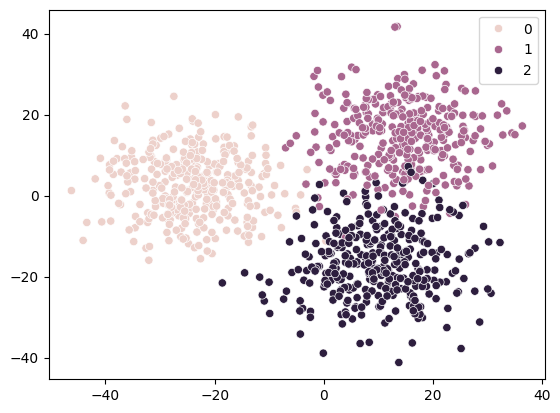

In [458]:
X, y, centers = make_blobs(centers=3, cluster_std=8, n_features=25, n_samples=1000, return_centers=True)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [459]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x17,x18,x19,x20,x21,x22,x23,x24,x25,label
0,-3.388414,5.284061,16.968900,-6.299025,-8.842274,-1.070744,4.090618,-4.853318,1.496381,-20.838923,...,10.857059,4.625100,-2.873261,-8.338235,-4.888791,-3.554615,-19.510302,1.263194,12.409754,1.0
1,0.571933,-5.815861,7.146175,-1.697861,4.263084,18.402024,-8.288283,-6.549486,-0.812291,8.594928,...,-6.076797,-7.206178,-1.751859,-6.184297,-10.041066,-20.650907,-9.333429,-1.293497,1.569128,2.0
2,2.236979,-9.437057,11.859703,-9.026773,-2.486663,3.525242,-1.736017,5.935873,-5.451702,-8.564240,...,2.226034,-5.196142,-4.561917,7.912098,13.402653,-7.605301,1.019905,6.479886,4.097503,0.0
3,-18.321460,1.005777,0.864568,-3.567784,-6.891350,-5.759032,-6.150935,-4.435508,-7.797146,0.117282,...,-1.399839,20.740308,-7.713543,-3.130394,-6.312538,4.980267,-7.015731,-0.244449,-6.864080,2.0
4,9.364200,-12.071485,28.942677,-1.732232,3.500416,14.532483,8.046465,-3.276503,-1.367049,-4.798469,...,-3.816514,-1.631687,5.998846,6.382666,4.461534,-2.604535,-22.393672,-6.500757,-9.147911,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10.073660,2.264799,4.800541,6.318437,2.735856,11.034121,-1.796183,5.741775,-5.997948,-13.728106,...,-1.577497,24.027000,3.475068,-1.082790,14.665300,-14.448925,21.826861,14.413057,-6.136043,0.0
996,15.200207,11.650781,15.781105,-17.066987,-17.818084,3.847833,10.923129,12.247643,-14.855343,1.698338,...,7.812195,14.639244,0.151952,11.836294,7.379503,0.577894,4.223345,10.478349,-19.022273,0.0
997,-12.587499,3.363845,0.351499,-12.815034,-5.228448,6.497140,-4.352622,-3.557567,13.429625,1.373785,...,-3.069889,-2.890812,11.440795,-17.593294,-8.724374,-19.614591,-14.515817,-4.829166,6.327222,1.0
998,4.289529,-7.708576,-6.087295,-18.435426,-8.711255,2.727166,-14.646588,-9.977529,-3.313052,12.465814,...,-7.628810,-3.093252,13.415529,-9.405321,-15.216947,-9.241611,-11.464499,5.501744,-6.017350,2.0


In [460]:
x,cf,h = Simple_CF_Descent(df=df, target=1.0, centers=centers)

In [461]:
cf_pca = pca.transform([cf])[0]

h_pca = pca.transform(h)

hx = list(zip(*h_pca))[0]
hy = list(zip(*h_pca))[1]

x_pca = pca.transform([x])[0]

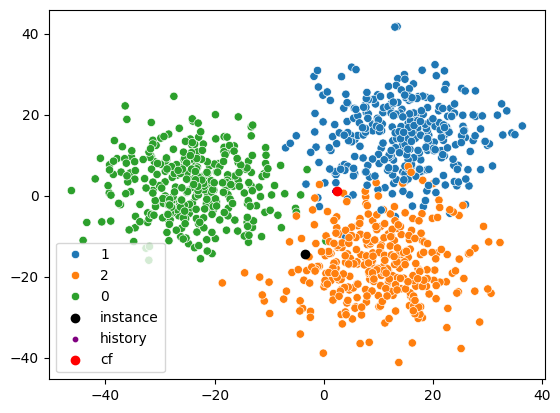

In [462]:

sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)
plt.scatter(x=x_pca[0],y=x_pca[1],color='black',label='instance')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.scatter(x=cf_pca[0],y=cf_pca[1],color='red', label='cf')
plt.legend()